# Fit emimTF2N data

EoS: SRK

Parameter T dependence: Constant, 1 parameter - emimTF2N,r32 pair

N (total fitting parameters): 1

## Import Functions

In [1]:
import idaes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

import sys
sys.path.append('../../')

from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)
from pyomo.opt import TerminationCondition, SolverStatus

from idaes.core import FlowsheetBlock
import idaes.logger as idaeslog
# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)
# Import unit models from the model library
from idaes.generic_models.unit_models import Flash
# Import degrees of freedom tool
from idaes.core.util.model_statistics import degrees_of_freedom

# parmest (binary_param2)
from bip_fitting_functions_SRK import constant

import scipy.stats as stats

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import matplotlib.patches as mpatches

## Load Data

In [2]:
data_full = pd.read_csv('r32_emimtf2n_full.csv')
data_subset = pd.read_csv('r32_emimtf2n_subset.csv')

## Load Configuration + Check DOF

In [3]:
from hfc32_emimtf2n_SRK import configuration 

In [4]:
m = ConcreteModel()
m.fs = FlowsheetBlock(default={"dynamic": False})
m.fs.properties = GenericParameterBlock(default=configuration)
m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})
DOF_initial = degrees_of_freedom(m)
print('The initial DOF is {0}'.format(DOF_initial))

    (ordered) position is deprecated.  Please use at()  (deprecated in 6.1,
    will be removed in 7.0) (called from /Users/bridgettebefort/Dowling-
    Maginn-Lab/DowlingLab/IL-MD/idaes-
    pse/idaes/generic_models/properties/core/state_definitions/FTPx.py:178)
The initial DOF is 7


## Fit Parameters

In [5]:
parameters, obj_value, a = constant(data_subset, configuration, 'R32', 'emimTf2N', "x_R32", "x_emimTf2N", 
    init_temp =  298.15, init_press =   399400 , init_x_c1 =    0.417, init_x_c2 = 0.583,
    init_kappa_A_2_1 = 0.028, init_kappa_A_1_2 = 0.0, eps = 0.1, scaling_fac = 1e-9 , read=False, optional_params='Opt2')

2022-01-17 15:21:52 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-01-17 15:21:53 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-01-17 15:21:54 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-01-17 15:21:54 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-01-17 15:21:54 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-01-17 15:21:55 [INFO] idaes.init.fs.state_block: Property package initialization: infeasible - Converged to a locally infeasible point. Problem may be infeasible..
2022-01-17 15:21:55 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-01-17 15:21:56 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal 

/Users/bridgettebefort/opt/anaconda3/envs/idaes-pse-dev/lib/python3.7/site-packages/pyomo/contrib/interior_point/interface.py:418: RuntimeWarning: divide by zero encountered in true_divide
  data = (duals_primals_lb/(primals - self._nlp.primals_lb()) +


In [6]:
print('Objective (SSE):',obj_value)

Objective (SSE): 45.25470390699907


In [7]:
cov = np.array(a)
print('Covariance Matrix:')
print(cov)

Covariance Matrix:
[[1.83230905e-13]]


In [8]:
np.savetxt('Data/Covariance/SRK_Cov_1parameter_ILHFCfit.csv',cov,delimiter=',')

## Apply Parameters + Plot

In [9]:
solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6}

In [11]:
m = ConcreteModel()

m.fs = FlowsheetBlock(default={"dynamic": False})

m.fs.properties = GenericParameterBlock(default=configuration)

m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})

m.fs.F101.inlet.flow_mol.fix(1)
m.fs.F101.inlet.temperature.fix(323.15)
m.fs.F101.inlet.pressure.fix(399800)
m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(0.5)

# m.fs.properties.PR_kappa_A['R32','emimTf2N'] = parameters['fs.properties.PR_kappa_A[R32,emimTf2N]']
m.fs.properties.SRK_kappa_A['emimTf2N','R32'] = parameters['fs.properties.SRK_kappa_A[emimTf2N,R32]']

# Initialize the flash unit
m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

# Fix the state variables on the state block
# m.fs.F101.inlet.pressure.unfix()
m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].unfix()

R32_x = np.zeros((len(data_full)))
P = np.zeros((len(data_full)))

m.fs.liq = Param(mutable=True,default=0.040)
m.fs.liquid = Constraint(expr=m.fs.F101.liq_outlet.mole_frac_comp[0, "emimTf2N"] == m.fs.liq)

for i in range(len(data_full)):
    m.fs.liq = data_full["x_emimTf2N"].iloc[i]
    m.fs.F101.inlet.temperature.fix(float(data_full["temperature"].iloc[i]))
    m.fs.F101.inlet.pressure.fix(float(data_full["pressure"].iloc[i]))
    m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(float(data_full["x_R32"].iloc[i])+0.1)
    m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].fix(float(1-(data_full["x_R32"].iloc[i]+0.1)))
    m.fs.F101.vap_outlet.temperature.fix(float(data_full["temperature"].iloc[i]))
    
#     DOF_final = degrees_of_freedom(m)
#     print("The final DOF is {0}".format(DOF_final))
    m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)
    
    status = solver.solve(m, tee = False)

#     m.fs.F101.report()
    if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):
        print(data_full["x_emimTf2N"].iloc[i])
        R32_x[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R32']) 
        P[i] = value(m.fs.F101.vap_outlet.pressure[0])

    else:
        print('Infeasible.')

0.986
0.864
0.694
0.552
0.43
0.328
0.214
0.99
0.905
0.782
0.675
0.583
0.501
0.43
0.357
0.995
0.945
0.867
0.8
0.736
0.68
0.632
0.583
0.998
0.966
0.916
0.869
0.825
0.784
0.746
0.712


In [12]:
fitted_data = pd.DataFrame(data=[R32_x,P/1e6])
fitted_data = fitted_data.T
fitted_data.columns = ['R32_x','P, MPa']
fitted_data.to_csv('Data/Fits/SRK_FittedData_1parameter_ILHFCfit.csv')

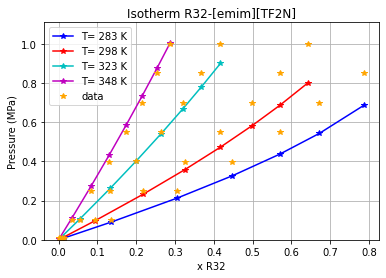

In [13]:
P1= np.zeros((len(P)))

for i in range(len(P)):
    P1[i] = P[i]/1e6

plt.plot(R32_x[0:7],P1[0:7],"b*-",label="T= 283 K")  
plt.plot(R32_x[7:15],P1[7:15],"r*-",label="T= 298 K") 
plt.plot(R32_x[15:23],P1[15:23],"c*-",label="T= 323 K") 
plt.plot(R32_x[23:31],P1[23:31],"m-*",label="T= 348 K")
plt.plot(data_full["x_R32"],data_full["pressure"]/1e6,"*",color='orange',label="data")  
plt.title('Isotherm R32-[emim][TF2N]')
plt.ylabel('Pressure (MPa)')
plt.xlabel('x R32')
plt.grid(True)
plt.ylim(0,1.110000)
plt.legend()
plt.show()

### Print Eigvals, Eigvectors of Covariance

An identifiability analysis can be performed with these as well as a FIM because the covariance matrix is the inverse of the FIM. That means that if there are any eigvals >> 0, their eigvecs indicate directions of un-identifiability.

In [14]:
eigvals, eigvecs = np.linalg.eig(cov)

In [15]:
eigvals

array([1.83230905e-13])

In [16]:
eigvecs

array([[1.]])

In [17]:
np.savetxt('Data/EigenAnalysis/SRK_vals_1parameter_ILHFCfit.csv',eigvals,delimiter=',')
np.savetxt('Data/EigenAnalysis/SRK_vecs_1parameter_ILHFCfit.csv',eigvecs,delimiter=',')

Conclusion: Fully identifiable because all eigvals ~ 0 

## FIM with Enthalpy of Vaporization (and Pressure)

### Step 1: Perturb Parameters, Calculate Enthalpy of Vaporization

1. Perturb Parameters: stepsize = 0.001

2. Holding all other parameters constant, calculate new pressure predictions at different temps, compositions 

*T = (T1=298, T2=323)

*x = (0.01,0.2,0.325,0.4)

*Pguess comes from data_full

3. Save P, Use Clausius Clapeyron to calculate enthvap

In [ ]:
h = 0.001
kR32_emimTF2N_plus = parameters['fs.properties.PR_kappa_A[R32,emimTf2N]'] + h
kR32_emimTF2N_minus = parameters['fs.properties.PR_kappa_A[R32,emimTf2N]'] - h
kemimTF2N_R32_plus = parameters['fs.properties.PR_kappa_A[emimTf2N,R32]'] + h
kemimTF2N_R32_minus = parameters['fs.properties.PR_kappa_A[emimTf2N,R32]'] - h

In [ ]:
data = np.array([[kR32_emimTF2N_plus,parameters['fs.properties.PR_kappa_A[emimTf2N,R32]']],
                [kR32_emimTF2N_minus,parameters['fs.properties.PR_kappa_A[emimTf2N,R32]']],
                [parameters['fs.properties.PR_kappa_A[R32,emimTf2N]'],kemimTF2N_R32_plus],
               [parameters['fs.properties.PR_kappa_A[R32,emimTf2N]'],kemimTF2N_R32_minus]])

In [ ]:
perturbed_params = pd.DataFrame(data=data,columns=['kR32_emimTF2N','kemimTF2N_R32'])
perturbed_params

In [ ]:
x = [0.01,0.2,0.325,0.4]
temps_298 = [298.15,298.15,298.15,298.15]
pguess_298 = [9600,250000,399400,549000]
temps_323 = [323.15,323.15,323.15,323.15]
pguess_323 = [20400,400100,700300,1000000]

In [ ]:
test_298 = pd.DataFrame()
test_298['temperature'] = temps_298
test_298['pressure'] = pguess_298
test_298['x_R32'] = x
test_298['x_emimTf2N'] = 1-test_298['x_R32']
# test_298

In [ ]:
test_323 = pd.DataFrame()
test_323['temperature'] = temps_323
test_323['pressure'] = pguess_323
test_323['x_R32'] = x
test_323['x_emimTf2N'] = 1-test_323['x_R32']
# test_323

In [ ]:
test_data = pd.concat([test_298,test_323],ignore_index=True)

In [ ]:
# Loop through test values

R32_x = np.zeros((len(perturbed_params),len(test_data)))
P = np.zeros((len(perturbed_params),len(test_data)))

for j in range(len(perturbed_params)):

    m = ConcreteModel()

    m.fs = FlowsheetBlock(default={"dynamic": False})

    m.fs.properties = GenericParameterBlock(default=configuration)

    m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                               "has_heat_transfer": True,
                               "has_pressure_change": True})

    m.fs.F101.inlet.flow_mol.fix(1)
    m.fs.F101.inlet.temperature.fix(323.15)
    m.fs.F101.inlet.pressure.fix(399800)
    m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(0.5)

    m.fs.properties.PR_kappa_A['R32','emimTf2N'] = perturbed_params['kR32_emimTF2N'][j]
    m.fs.properties.PR_kappa_A['emimTf2N','R32'] = perturbed_params['kemimTF2N_R32'][j]

    # Initialize the flash unit
    m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

    # Fix the state variables on the state block
    # m.fs.F101.inlet.pressure.unfix()
    m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].unfix()

    m.fs.liq = Param(mutable=True,default=0.040)
    m.fs.liquid = Constraint(expr=m.fs.F101.liq_outlet.mole_frac_comp[0, "emimTf2N"] == m.fs.liq)

    for i in range(len(test_data)):
        m.fs.liq = test_data["x_emimTf2N"].iloc[i]
        m.fs.F101.inlet.temperature.fix(float(test_data["temperature"].iloc[i]))
        m.fs.F101.inlet.pressure.fix(float(test_data["pressure"].iloc[i]))
        m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(float(test_data["x_R32"].iloc[i])+0.1)
        m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].fix(float(1-(test_data["x_R32"].iloc[i]+0.1)))
        m.fs.F101.vap_outlet.temperature.fix(float(test_data["temperature"].iloc[i]))

    #     DOF_final = degrees_of_freedom(m)
    #     print("The final DOF is {0}".format(DOF_final))
        m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

        status = solver.solve(m, tee = False)

    #     m.fs.F101.report()
        if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):
            print(test_data["x_emimTf2N"].iloc[i])
            R32_x[j,i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R32'])
            P[j,i] = value(m.fs.F101.vap_outlet.pressure[0])

        else:
            print('Infeasible.')

In [ ]:
test_data['P_kR32_emimTF2N_plus'] = P[0]
test_data['P_kR32_emimTF2N_minus'] = P[1]
test_data['P_kemimTF2N_R32_plus'] = P[2]
test_data['P_kemimTF2N_R32_minus'] = P[3]

In [ ]:
grad_P = test_data

In [ ]:
test_data_298 = test_data[test_data['temperature']==298.15]
test_data_323 = test_data[test_data['temperature']==323.15].reset_index()

In [ ]:
R = 8.314 #J/mol-K
hvap_calc_kR32_emimTF2N_plus = []
for i in range(len(x)):
    T2 = test_data_323['temperature'][i]
    T1 = test_data_298['temperature'][i]
    P2 = test_data_323['P_kR32_emimTF2N_plus'][i]
    P1 = test_data_298['P_kR32_emimTF2N_plus'][i]
    hvap_calc_kR32_emimTF2N_plus.append(np.log(P2/P1)*R/(1/T2-1/T1))

hvap_calc_kR32_emimTF2N_minus = []
for i in range(len(x)):
    T2 = test_data_323['temperature'][i]
    T1 = test_data_298['temperature'][i]
    P2 = test_data_323['P_kR32_emimTF2N_minus'][i]
    P1 = test_data_298['P_kR32_emimTF2N_minus'][i]
    hvap_calc_kR32_emimTF2N_minus.append(np.log(P2/P1)*R/(1/T2-1/T1))
    
hvap_calc_kemimTF2N_R32_plus = []
for i in range(len(x)):
    T2 = test_data_323['temperature'][i]
    T1 = test_data_298['temperature'][i]
    P2 = test_data_323['P_kemimTF2N_R32_plus'][i]
    P1 = test_data_298['P_kemimTF2N_R32_plus'][i]
    hvap_calc_kemimTF2N_R32_plus.append(np.log(P2/P1)*R/(1/T2-1/T1))
    
hvap_calc_kemimTF2N_R32_minus = []
for i in range(len(x)):
    T2 = test_data_323['temperature'][i]
    T1 = test_data_298['temperature'][i]
    P2 = test_data_323['P_kemimTF2N_R32_minus'][i]
    P1 = test_data_298['P_kemimTF2N_R32_minus'][i]
    hvap_calc_kemimTF2N_R32_minus.append(np.log(P2/P1)*R/(1/T2-1/T1))

In [ ]:
hvap = pd.DataFrame()
hvap['x_R32'] = x
hvap['hvap_kR32_emimTF2N_plus'] = hvap_calc_kR32_emimTF2N_plus
hvap['hvap_kR32_emimTF2N_minus'] = hvap_calc_kR32_emimTF2N_minus
hvap['hvap_kemimTF2N_R32_plus'] = hvap_calc_kemimTF2N_R32_plus
hvap['hvap_kemimTF2N_R32_minus'] = hvap_calc_kemimTF2N_R32_minus

In [ ]:
hvap

### Step 2: Calculate Gradient wrt each param at each concentration

In [ ]:
grad_kR32_emimTF2N = (hvap['hvap_kR32_emimTF2N_plus'] - hvap['hvap_kR32_emimTF2N_minus'])/(2*h)
grad_kemimTF2N_R32 = (hvap['hvap_kemimTF2N_R32_plus'] - hvap['hvap_kemimTF2N_R32_minus'])/(2*h)

In [ ]:
grad_P['kR32_emimTF2N'] = (grad_P['P_kR32_emimTF2N_plus'] - grad_P['P_kR32_emimTF2N_minus'])/(2*h)
grad_P['kemimTF2N_R32'] = (grad_P['P_kemimTF2N_R32_plus'] - grad_P['P_kemimTF2N_R32_minus'])/(2*h)

### Step 3: Build Jacobian and FIM

Rows: enthvap @ 4 concentrations; or pressure @ 4 concentrations, 2 temperatures

Columns: parameters (2)

In [ ]:
J_df = pd.DataFrame()
J_df['kR32_emimTF2N'] = grad_kR32_emimTF2N
J_df['kemimTF2N_R32'] = grad_kemimTF2N_R32

In [ ]:
J = J_df.to_numpy()
Jtrans = np.transpose(J)

In [ ]:
FIM = np.dot(Jtrans,J)

In [ ]:
FIM

In [ ]:
J_df_P = pd.DataFrame()
J_df_P['kR32_emimTF2N'] = grad_P['kR32_emimTF2N']
J_df_P['kemimTF2N_R32'] = grad_P['kemimTF2N_R32']

In [ ]:
J_P = J_df_P.to_numpy()
J_Ptrans = np.transpose(J_P)

In [ ]:
FIM_P = np.dot(J_Ptrans,J_P)

In [ ]:
FIM_P

### Step 4: Find Eigenvalues, Eigenvectors

**Enthalpy of Vaporization**

In [ ]:
eigvals, eigvecs = np.linalg.eig(FIM)

In [ ]:
eigvals

In [ ]:
eigvecs

All eigenvalues >> 0, assuming that these 2 parameters are identifiable with the given T, x, P data

**Pressure**

In [ ]:
eigvals_P, eigvecs_P = np.linalg.eig(FIM_P)

In [ ]:
eigvals_P

In [ ]:
eigvecs_P

All eigvals >> 0, assuming these 2 parameters are identifiable with the given T, x, P data

## AIC Value

See https://docs.google.com/document/d/1um0r2XK4ldjjy2colOqaZsEM3wIzGD6l_3B8gnpnI2I/edit# for equations

In [18]:
n = 1

In [19]:
SSR = obj_value
SSR

45.25470390699907

In [20]:
sigma_sq = SSR/n
sigma_sq

45.25470390699907

In [21]:
L = -n/2*np.log(2*np.pi) - n/2*np.log(sigma_sq) - 1/(2*sigma_sq)*SSR
L

-3.32509184244915

In [22]:
AIC = 2*n - 2*L
AIC

8.6501836848983

In [23]:
AIC_data = pd.DataFrame(data=[n,obj_value,AIC])
AIC_data = AIC_data.T
AIC_data.columns = ['n','Objective, Pa^2','AIC']
AIC_data.to_csv('Data/AIC/SRK_AIC_1parameter_ILHFCfit.csv')